In [87]:
import gc
import lightgbm as lgb
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import random
import sys
import time
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
from pandarallel import pandarallel
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [46]:
from pathlib import Path
rootpath = Path.cwd().parent
sys.path.append(os.path.join(rootpath))

In [66]:
from utils.constants import *
from utils.eda_helpers import (
    plot_missing_proportion_barchart, get_cols, plot_scatterplot, plot_target_check, 
    plot_int_feature_distribution, plot_train_test_distribution, check_overlap_missing,
    insert_row_number, plot_sampled_time_series, plot_heatmap
)
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, BINARY_COLUMNS,
    MEAN_FEATURES, MIN_FEATURES, MAX_FEATURES, LAST_FEATURES, NON_FEATURE_COLUMNS
)
from utils.preprocess_helpers import *
from utils.feature_engineering_helpers import feature_gen_pipeline

In [67]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setup

In [5]:
%%time
integer_train = read_file(f"{INTERIM_DATA_PATH}/v0/train_integer_master.parquet")

Shape of data: (5531451, 190)
CPU times: user 4.49 s, sys: 4.99 s, total: 9.48 s
Wall time: 7.18 s


In [6]:
%%time
labels = pd.read_csv(f"{RAW_DATA_PATH}/train_labels.csv")
if "target" not in integer_train.columns:
    integer_train = integer_train.merge(labels, on="customer_ID", how="left")

CPU times: user 1.33 s, sys: 784 ms, total: 2.11 s
Wall time: 2.54 s


In [7]:
%%time
train = read_file(f"{INTERIM_DATA_PATH}/v2/train_parquet/train_all_variables.parquet")
test = read_file(f"{INTERIM_DATA_PATH}/v2/test_parquet/test_all_variables.parquet")

Shape of data: (5531451, 190)
Shape of data: (11363762, 189)
CPU times: user 17 s, sys: 29.8 s, total: 46.9 s
Wall time: 33.3 s


In [8]:
%%time
public_test, private_test = split_public_private(test)

Public size: 5719469, Private size: 5644293
CPU times: user 4.72 s, sys: 10.1 s, total: 14.8 s
Wall time: 21.3 s


In [9]:
del test

In [10]:
df_list = [train, public_test, private_test]

In [52]:
for df in df_list:
    insert_row_number(df)

Done insertion
Done insertion
Done insertion


In [ ]:
params = {
    'objective': 'binary',
    'metric': "binary_logloss",
    'boosting': 'dart',
    'seed': 1020,
    'num_leaves': 60,
    'learning_rate': 0.02,
    'feature_fraction': 0.25,
    'bagging_freq': 10,
    'bagging_fraction': 0.6,
    'n_jobs': -1,
    'lambda_l2': 15,
    'min_data_in_leaf': 100,
    'scale_pos_weight': 1.4
}

In [98]:
strong_columns = ["P_2", "B_4", "D_39", "D_43", "S_3", "D_48", "B_3", "D_46", "P_3", "S_7", "B_40"]

In [11]:
train_corr_df = pd.read_csv(f"{PROCESSED_DATA_PATH}/raw_column_correlation/train_corr_df.csv")
train_corr_df.insert(0, "column", train_corr_df.columns.tolist())

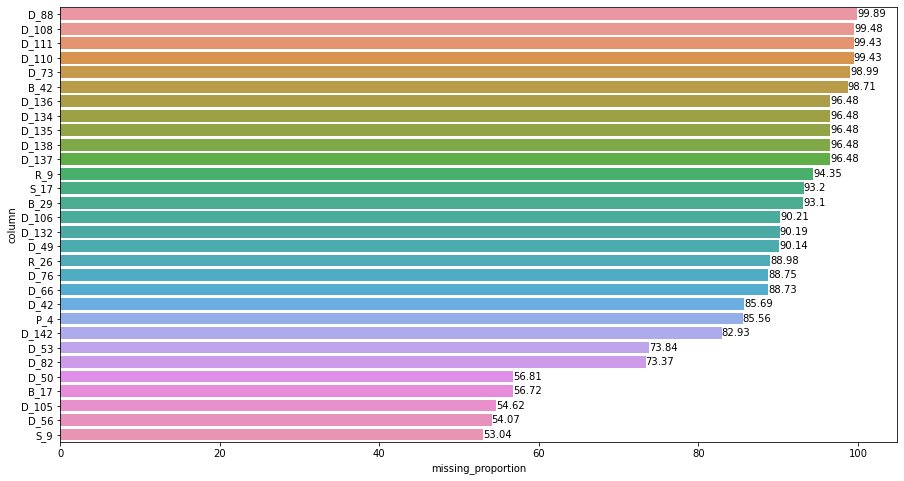

In [13]:
m = plot_missing_proportion_barchart(train)

In [21]:
missing_group_df = m.groupby("missing_proportion")["column"].count().sort_values(ascending=False).reset_index()

### Missing Feature Group 1

In [30]:
index = 0
m_prop = missing_group_df["missing_proportion"][index]
m_prop

3.1947494427773107

In [181]:
sorted(missing_feature_g1)

['D_113',
 'D_114',
 'D_115',
 'D_116',
 'D_117',
 'D_118',
 'D_119',
 'D_120',
 'D_121',
 'D_122',
 'D_123',
 'D_124',
 'D_125']

In [31]:
missing_feature_g1 = m.loc[m["missing_proportion"] == m_prop, "column"].tolist()

In [100]:
# plot_heatmap(temp.loc[:, missing_feature_g1].corr(), annot=True, fmt=".2f", figsize=(18, 12))

In [101]:
missing_cid_list = temp.loc[temp["D_124"].isnull(), "customer_ID"].tolist()

In [145]:
# plot_target_check(train, "D_124", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [124]:
# temp.loc[temp["customer_ID"].isin(missing_cid_list)]

In [226]:
temp = train.loc[:, ["customer_ID", "S_2", "row_number", "target"] + missing_feature_g1 + strong_columns]

In [227]:
# for d_col in tqdm(missing_feature_g1):
#     temp[d_col] = temp.groupby("customer_ID")[d_col].apply(lambda x: x.interpolate("linear"))

In [ ]:
for d_col in tqdm(missing_feature_g1):
    temp[d_col] = temp.groupby("customer_ID")[d_col].apply(lambda x: x.ffill().bfill())

 31%|█████████████████████████████████████████▏                                                                                            | 4/13 [01:58<04:25, 29.55s/it]

In [188]:
# for col in missing_feature_g1:
#     if col not in CATEGORY_COLUMNS:
#         print(col)
#         plot_target_check(temp, col, q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [207]:
for d_col in tqdm(missing_feature_g1):
    temp[d_col] = temp[d_col].fillna(temp[d_col].mode)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 29.21it/s]


In [208]:
%%time
cat_features = set(CATEGORY_COLUMNS).intersection(temp.columns)
temp.loc[:, cat_features] = temp.loc[:, cat_features].astype("category")
temp_agg = feature_gen_pipeline(temp)

Done insertion
Average done
Minimum done
Maximum done
Standard Deviation done
Last entry done
First entry done
Second last entry done
Third last entry done
MA2 for Recency 1 done
MA2 for Recency 2 done
MA2 for Recency 3 done
MA2 for least Recency done
MA3 for Recency 1 done
MA3 for Recency 2 done


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:41<00:00,  1.97s/it]


CPU times: user 30.1 s, sys: 22.1 s, total: 52.3 s
Wall time: 56 s


In [209]:
temp_agg.shape, labels.shape

((458913, 499), (458913, 2))

In [222]:
X_train, X_val, y_train, y_val = train_test_split(temp_agg, labels["target"], test_size=0.22, random_state=6846)

In [223]:
cat_features = set(CATEGORY_COLUMNS).intersection(X_train.columns)

In [224]:
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=cat_features)
lgb_valid = lgb.Dataset(X_val, y_val, categorical_feature=cat_features)
model = lgb.train(
    params = params,
    train_set = lgb_train,
    num_boost_round = 500,
    valid_sets = [lgb_train, lgb_valid],
    early_stopping_rounds = 300,
    verbose_eval = 50,
    feval = lgb_amex_metric
)

[LightGBM] [Info] Number of positive: 92555, number of negative: 265397
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 88548
[LightGBM] [Info] Number of data points in the train set: 357952, number of used features: 496
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258568 -> initscore=-1.053424
[LightGBM] [Info] Start training from score -1.053424
[50]	training's binary_logloss: 0.420464	training's amex: 0.73827	valid_1's binary_logloss: 0.42229	valid_1's amex: 0.732003
[100]	training's binary_logloss: 0.354024	training's amex: 0.744692	valid_1's binary_logloss: 0.356503	valid_1's amex: 0.73861
[150]	training's binary_logloss: 0.346472	training's amex: 0.747214	valid_1's binary_logloss: 0.349102	valid_1's amex: 0.741212
[200]	training's binary_logloss: 0.32418	training's ame

In [225]:
y_val_pred = model.predict(X_val, raw_score=True)
val_score, val_g, val_t4 = amex_metric(y_val.values, y_val_pred)
val_score, val_g, val_t4

(0.7517767257542728, 0.9013001877015955, 0.6022532638069501)

In [109]:
# plot_scatterplot(train, "D_118", "D_119")
# plt.show()

### S_11

In [ ]:
plot_target_check(train, "S_11", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [ ]:
plot_train_test_distribution(df_list, "S_11", nunique_thr=150, figsize=(24, 9))

In [ ]:
train_corr_df["temp"] = train_corr_df["S_11"].abs()
train_corr_df.nlargest(5, "temp")[["column", "temp"]]

In [ ]:
train["S_13"].value_counts().iloc[:15]

In [ ]:
temp = train.loc[train["S_13"] == 1]

In [ ]:
# temp["S_11"].value_counts()

In [ ]:
for value in sorted(train["S_13"].unique().tolist()):
    if value != value:
        continue
    print(value)
    temp = train.loc[train["S_13"] == value]
    print(temp.shape)
    plot_target_check(temp, "S_11", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, figsize=(14, 6))

In [ ]:
# train["temp"] = train["S_11"] / train["S_13"]
# train["temp_mean"] = train["S_13"].map(dict(train.groupby(["S_13"])["S_11"].mean()))
# train["S_11a"] = train["S_11"] / train["temp_mean"]

In [ ]:
# plot_scatterplot(train, "S_13", "S_11", hue_column="target", ticksize=12, figsize=(12, 7))

In [ ]:
# plot_scatterplot(integer_train, "S_13", "S_11", hue_column="target", ticksize=12, figsize=(12, 7))

### S_12

In [ ]:
plot_target_check(train, "S_12", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [ ]:
train_corr_df["temp"] = train_corr_df["S_12"].abs()
train_corr_df.nlargest(5, "temp")[["column", "temp"]]

In [ ]:
train["S_12"].describe()

In [ ]:
# plot_scatterplot(train.loc[train["S_12"].between(0, 1)], "S_12", "S_13")#, size="pop")

In [ ]:
s12_min_max_df = train.groupby("customer_ID").agg(
    s12_max=("S_12", "max"), 
    s12_min=("S_12", "min")
)

In [ ]:
s12_min_max_df.shape

In [ ]:
s12_min_max_df

In [ ]:
pass_cid_list = s12_min_max_df.loc[(s12_min_max_df["s12_min"] >= 0.18) & (s12_min_max_df["s12_max"] <= 0.19)].index.tolist()

In [ ]:
train["S_12_"] = train["S_12"].values

In [ ]:
train.shape

In [ ]:
train.loc[~train["customer_ID"].isin(pass_cid_list), "S_12_"].shape

In [ ]:
train.loc[~train["customer_ID"].isin(pass_cid_list), "S_12_"] = train.loc[
    ~train["customer_ID"].isin(pass_cid_list), "S_12_"
].replace((0.18, 0.19), np.nan)

In [ ]:
plot_target_check(train, "S_12_", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [ ]:
t = s12_min_max_df.loc[s12_min_max_df["s12_max"] == s12_min_max_df["s12_min"]]
sus_cid_list = t.loc[t["s12_min"].between(0.18, 0.19)].index.tolist()

In [ ]:
train.loc[train["customer_ID"].isin(sus_cid_list), "S_12_"] = np.nan

In [ ]:
train["S_12"]